# T&D Clusterization

Este notebook tem como objetivo realizar todos os passos até a execução de um modelo de aprendizado de máquina de clusterização para identificar os consumidores felizes ou tristes de acordo com as avaliações realizadas.

O dataset utilizado é uma base de dados de uma loja brasileira de ecommerce, disponível em: [Link do Dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)
 
Os passos definidos são:
1. Importação de dados e formação de tabelas delta;
2. Análise de dados & formação da tabela base de clusterização;
3. Pré-processamento e feature selection;
4. Clusterização;
5. Avaliação e análise dos clusters;
6. Conclusão.

**Este notebook pertence a:** eric.yoshida 

Links:
**[GitHub](https://github.com/faduzin)**
**[LinkedIn](https://www.linkedin.com/in/ericfadul/)**

## Importação de dados e formação de tabelas delta

In [10]:
import pyspark
import pyspark.sql.functions as F
import pyspark.mllib
import os
import shutil
import pandas as pd
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)


In [2]:
builder = (
    SparkSession.builder
        .appName("ml_clustering")
        .master("local[8]")
        .config("spark.driver.memory", "12g")
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

In [18]:
path = r"C:\Users\Eric Yoshida\Documents\repos\t-d-clusterization\data\brazillian_ecommerce"

file_name_map = {
    'olist_customers_dataset.csv'           : 'customers',
    'olist_geolocation_dataset.csv'         : 'geolocation',
    'olist_order_items_dataset.csv'         : 'items',
    'olist_order_payments_dataset.csv'      : 'payments',
    'olist_order_reviews_dataset.csv'       : 'reviews',
    'olist_orders_dataset.csv'              : 'orders',
    'olist_products_dataset.csv'            : 'products',
    'olist_sellers_dataset.csv'             : 'sellers',
    'product_category_name_translation.csv' : 'product_translation'
}

In [19]:
# File location and type
def save_as_delta(csv_path, name, infer_schema="true", first_row_is_header="true", delimiter=","):
    file_type = "csv"
    output_path = os.path.join(r"C:\Users\Eric Yoshida\Documents\repos\t-d-clusterization\data\delta_tables", name)

    if os.path.exists(output_path):
        shutil.rmtree(output_path, ignore_errors=True)

    # The applied options are for CSV files. For other file types, these will be ignored.
    df = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(csv_path)
    )

    print(f"Saving: {csv_path} → {output_path}")
    df.write.format("delta").mode("overwrite").save(output_path)

In [20]:
for file in os.listdir(path):
    full_file_path = os.path.join(path, file)
    delta_table_name = file_name_map.get(file)

    if delta_table_name:
        save_as_delta(full_file_path, delta_table_name)
    else:
        print(f"⚠️ Skipping file '{file}' — not in file_name_map")


Saving: C:\Users\Eric Yoshida\Documents\repos\t-d-clusterization\data\brazillian_ecommerce\olist_customers_dataset.csv → C:\Users\Eric Yoshida\Documents\repos\t-d-clusterization\data\delta_tables\customers
Saving: C:\Users\Eric Yoshida\Documents\repos\t-d-clusterization\data\brazillian_ecommerce\olist_geolocation_dataset.csv → C:\Users\Eric Yoshida\Documents\repos\t-d-clusterization\data\delta_tables\geolocation
Saving: C:\Users\Eric Yoshida\Documents\repos\t-d-clusterization\data\brazillian_ecommerce\olist_orders_dataset.csv → C:\Users\Eric Yoshida\Documents\repos\t-d-clusterization\data\delta_tables\orders
Saving: C:\Users\Eric Yoshida\Documents\repos\t-d-clusterization\data\brazillian_ecommerce\olist_order_items_dataset.csv → C:\Users\Eric Yoshida\Documents\repos\t-d-clusterization\data\delta_tables\items
Saving: C:\Users\Eric Yoshida\Documents\repos\t-d-clusterization\data\brazillian_ecommerce\olist_order_payments_dataset.csv → C:\Users\Eric Yoshida\Documents\repos\t-d-clusterizati

In [0]:
%sql show tables in brazillian_ecommerce


database,tableName,isTemporary
brazillian_ecommerce,customers,false
brazillian_ecommerce,geolocation,false
brazillian_ecommerce,items,false
brazillian_ecommerce,orders,false
brazillian_ecommerce,payments,false
brazillian_ecommerce,product_translation,false
brazillian_ecommerce,products,false
brazillian_ecommerce,reviews,false
brazillian_ecommerce,sellers,false


## Análise de dados & formação da tabela base de clusterização

### Tabelas

In [3]:
CUSTOMERS            = "./data/delta_tables/customers"
LOCATION             = "./data/delta_tables/geolocation"
ITEMS                = "./data/delta_tables/items"
ORDERS               = "./data/delta_tables/orders"
PAYMENTS             = "./data/delta_tables/payments"
PRODUCTS_TRANSLATION = "./data/delta_tables/product_translation"
PRODUCTS             = "./data/delta_tables/products"
REVIEWS              = "./data/delta_tables/reviews"
SELLERS              = "./data/delta_tables/sellers"

In [4]:
customers_df = spark.read.format("delta").load(CUSTOMERS)
location_df  = spark.read.format("delta").load(LOCATION)
items_df     = spark.read.format("delta").load(ITEMS)
orders_df    = spark.read.format("delta").load(ORDERS)
payments_df  = spark.read.format("delta").load(PAYMENTS)
products_df  = spark.read.format("delta").load(PRODUCTS)
reviews_df   = spark.read.format("delta").load(REVIEWS)
sellers_df   = spark.read.format("delta").load(SELLERS)

### Análise de dados

**Diagrama de relações**

![Relations](https://i.imgur.com/HRhd2Y0.png)

Conteúdo das tabelas:
- _brazillian_ecommerce.customers_: ID do usuário, CEP, cidade, estado;
- _brazillian_ecommerce.geolocation_: coordenadas da localização em função do CEP;
- _brazillian_ecommerce.items_: ID de ordem, quantidade do item, ID de produto, ID de vendedor, data limite de entrega, preço, peso;
- _brazillian_ecommerce.orders_: ID de ordem, ID de consumidor, status da ordem, timestamp da compra, data de aprovação, data de envio, data de recebimento, data de entrega estimada;
- _brazillian_ecommerce.payments_: ID de ordem, sequência de pagamento, tipo de pagamento, quantidade de installments, valor de pagamento;
- _brazillian_ecommerce.product_translation_: nome da categoria em português, nome da categoria em ingles;
- _brazillian_ecommerce.products_:ID do produto, categoria do produto, tamanho do nome do produto, tamanho da descrição do produto, quantidade de fotos do produto, peso em gramas, profundidade, altura, largura;
- _brazillian_ecommerce.reviews_: ID de avaliação, ID de ordem, nota, título de comentário, mensagem do comentário, data de avaliação, data de resposta;
- _brazillian_ecommerce.sellers_: ID de vendedor, CEP, cidade, estado;

A análise de tabelas mostra que:
1. A tabela customer somente contém dados referentes a localização do consumidor, ela não será utilizada no treinamento mas poderá ser utilizada para análise de viés geográfico apos a clusterização;
2. A tabela geolocation possivelmente será utilizada para análise de viés geográfico;
3. A tabela items será utilizada para identificar os items das ordens avaliadas;
4. A tabela orders será utilizada para identificar datas relacionadas a ordem avaliada;
5. A tabela payments será utilizada para identificar o tipo e valor de pagamento;
6. A tabela product será utilizada para identificar a categoria, peso e dimensões do produto;
7. A tabela reviews será a tabela base, pois contém informações de avaliação da compra.
8. A tabela sellers, semelhante a customers, possivelmente será utilizada para identificar viés geográfico.

### Formação da tabela base

Possibilidades:
- Criar uma coluna de delay de entrega, e então classificar como "no prazo", "atrasado", "antes do prazo", "não entregue" e utilizar tambem o order_status como classe: Para esse caso seria necessário utilizar um one hot encode, o que poderia gerar muitas features.
- Retirar pedidos não entregues da lista para utilizar o delay de entrega como um valor continuo: Seria necessário desconsiderar entregar que foram apenas aprovadas mas não enviadas ainda, e entregas canceladas tambémm.
- Remover dimensões do produto e manter somente o freight.
- Manter o tipo de pagamento e usar one hot encode, utilizar a quantidade de pagamentos e o valor total tambem.

In [5]:
# Expressões e definições

timestamp_pattern = "\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}"

In [7]:
reviews_df = (
    reviews_df
    .filter(
        (F.col("review_score").isNotNull()) &
        (F.col("review_score").rlike("^[0-5]$")) &
        (F.col("review_creation_date").isNotNull()) &
        (F.col("review_creation_date").rlike(timestamp_pattern)) &
        (F.col("review_answer_timestamp").isNotNull()) &
        (F.col("review_answer_timestamp").rlike(timestamp_pattern))
    )
    .withColumn("review_score", F.col("review_score").cast("int"))
    .withColumn("review_creation_date", F.col("review_creation_date").cast("timestamp"))
    .withColumn("review_answer_timestamp", F.col("review_answer_timestamp").cast("timestamp"))
    .drop('review_creation_date', 'review_answer_timestamp', 'review_comment_title','review_comment_message') # correlação muito baixa, provavel ruido, assim a medida foi descartada
)

In [8]:
items_df = (
    items_df
    .groupBy("order_id", "product_id", "seller_id", "price", "freight_value")
    .agg(F.max(F.col("order_item_id")).alias("item_quantity"))
)

In [9]:
payments_df = (
    payments_df
    .groupBy("order_id", "payment_installments")
    .agg(F.sum(F.col("payment_value")).alias("total_paid"))
)

In [10]:
cluster_df = (
    reviews_df
    .join(orders_df, on='order_id', how='left')
    .join(payments_df, on='order_id', how='left')
    .join(items_df, on='order_id', how='left')
    .join(products_df, on='product_id', how='left')
)

In [13]:
cluster_df.limit(20).toPandas()

,product_id,order_id,review_id,review_score,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,...,freight_value,item_quantity,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,7945bb528c42095fccdf46321742afce,0a001a3fae4c5478fd40c669ab7c7f48,e8e4fbf06cebc109d453f4c7c6ddc49e,5,5c66c2564730b91a30cfc39190fc7dc1,delivered,2018-05-12 19:04:30,2018-05-12 19:16:39,2018-05-15 14:07:00,2018-05-21 19:58:42,...,19.32,1.0,utilidades_domesticas,31.0,536.0,1.0,775.0,44.0,3.0,34.0
1,ee286d9b47b21317f08ef31202f0debd,20379a997b864417f763a970359229a6,9598097b55b11f759f971dc8fa6baa8c,5,f528c4fb0c9ccd50ce849b2753a9c004,delivered,2017-12-09 10:41:50,2017-12-09 12:19:28,2017-12-11 15:47:26,2017-12-12 21:18:55,...,34.69,1.0,cama_mesa_banho,53.0,415.0,2.0,17100.0,56.0,38.0,48.0
2,25707e90c7f4f672f8d1058a32d78982,4cf8e5fafb46ec3ef4e9b76e9eb2bf25,ea18540e2c6a65272e7f063004b9543c,5,17679c354e803265772e7ebda35857eb,delivered,2018-08-21 07:07:54,2018-08-21 07:30:14,2018-08-22 11:18:00,2018-08-29 20:38:53,...,18.56,1.0,esporte_lazer,39.0,799.0,3.0,725.0,23.0,23.0,23.0
3,55a1e3d39ace9c0b217f6c30b04d43c0,583174fbe37d3d5f0d6661be3aad1786,373cbeecea8286a2b66c97b1b157ec46,1,e545e697bb9d1b81e0a702121d4e94d5,canceled,2018-08-04 19:25:07,2018-08-05 19:24:33,NaT,NaT,...,9.38,1.0,malas_acessorios,29.0,895.0,2.0,550.0,45.0,15.0,35.0
4,3af4f5bb8b0616387fe23646fa94e256,937d5309f2f6bc3548d704f56ef83ed1,2cec2c7a5711c86d5827a5677adfb2a2,1,0738d18b6c59edcbd519a88a06569847,delivered,2018-03-17 16:17:21,2018-03-17 16:32:26,2018-03-20 15:48:59,2018-04-19 23:41:17,...,70.70,1.0,moveis_decoracao,54.0,769.0,1.0,11600.0,45.0,35.0,45.0
5,f68980d7981fcc92059f42a4fd82fb38,a4fa719430167664811c30680941ec40,937804d7a75c25090020af23e32afe48,5,a240ccd156413c662c6b890586035887,delivered,2018-08-06 20:56:23,2018-08-06 21:05:18,2018-08-09 15:07:00,2018-08-16 19:38:25,...,25.18,1.0,esporte_lazer,56.0,1531.0,1.0,650.0,34.0,15.0,12.0
6,None,cb4a79c1e6c9ae44302861e7602cc449,4d3c61768eb47216ecf732bbbd8bef3c,1,536f46cc0f2f2b1e40d056f7998f0254,unavailable,2017-12-06 15:46:07,2017-12-06 15:57:29,NaT,NaT,...,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,06f18114503e7543d81252fd61a53df8,d36c084b5daf9cfc67fb1164f2c2bd0b,3a5253f1ee3dbe252bb698ea1bdd4fb5,3,174686c8e1e322ec30471d0515448cfe,delivered,2017-09-25 15:17:56,2017-09-25 15:30:17,2017-09-29 19:59:48,2017-10-09 19:40:04,...,18.65,1.0,utilidades_domesticas,35.0,2816.0,1.0,1250.0,22.0,24.0,24.0
8,2beff60bb4c8a8f05065bce8148ed01e,de6a26eab8b3a87c4d4ec2e2a8c2495e,e06c059207dad93c6808dd69aad29217,2,5e5df9027ff599d21d2a72c0b225b6fd,delivered,2018-06-10 21:22:22,2018-06-10 21:37:19,2018-06-11 15:07:00,2018-06-15 17:56:20,...,15.23,1.0,None,NaN,NaN,NaN,450.0,20.0,22.0,20.0
9,d1c427060a0f73f6b889a5c7c61f2ac4,f9e4b658b201a9f2ecdecbb34bed034b,228ce5500dc1d8e020d8d1322874b6f0,5,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,...,45.12,1.0,informatica_acessorios,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0


In [18]:
def delay(col1, col2):
    return F.date_diff(F.col(col1), F.col(col2))

In [ ]:
display(
    cluster_df
    .withColumn("delivered_delay", delay("order_delivered_customer_date", "order_estimated_delivery_date"))
    .withColumnRenamed("order_item_id", "item_quantity")
    .withColumn("total_price", F.round(F.col("item_quantity") * F.col("price"), 2))
    .withColumn("price_variation", F.round(F.col("total_paid") - F.col("total_price"), 2))
    .withColumn("delivery_status",
                F.when(F.col("delivered_delay") < 0, "adiantada")
                .when(F.col("delivered_delay") == 0, "no prazo")
                .when(F.col("delivered_delay") > 20, "muito atrasada")
                .when(F.col("delivered_delay") > 0, "atrasada")
                .otherwise("não entregue"))
    .withColumn("order_status",
                F.when(F.col("order_status") == "unavailable", "failed")
                .when(F.col("order_status") == "canceled", "failed")
                .when(F.col("order_status") == "delivered", "completed")
                .when(F.col("order_status") == "processing", "pending")
                .when(F.col("order_status") == "invoiced", "pending")
                .when(F.col("order_status") == "shipping", "pending")
    )    
    .select("order_id", "customer_id", "seller_id", "review_score", "order_status", "delivery_status", "payment_installments", "price", "item_quantity", "total_price", "total_paid", "price_variation", "freight_value", "product_weight_g")
    .distinct()
    .filter(
        (F.col("seller_id").isNotNull()) &
        (F.col("total_paid").isNotNull()) &
        (F.col("product_weight_g").isNotNull())    
        )
    .describe()
    .toPandas()
)

,summary,order_id,customer_id,seller_id,review_score,order_status,delivery_status,payment_installments,price,item_quantity,total_price,total_paid,price_variation,freight_value,product_weight_g
0,count,98623,98623,98623,98623,98623,98623,98623,98623,98623,98623,98623,98623,98623,98623
1,mean,None,None,None,4.102714376970889,None,None,2.9507518530160306,124.21237652473717,1.147176622086126,136.2299286170475,161.45581781126143,25.225889194204324,20.122572118066117,2085.479462194417
2,stddev,None,None,None,1.3312003965460966,None,None,2.740568495689426,187.57208742884313,0.5536160726720158,207.03423069929917,216.73214233823384,54.82470546542597,15.88360895652226,3740.7599373721087
3,min,00010242fe8c5a6d1ba2dd792cb16214,00012a2ce6f8dcda20d059ce98491703,0015a82c2db000af6aaaf3ae2ecb0532,1,approved,adiantada,0,0.85,1,0.85,0.01,-3763.56,0.0,0
4,max,fffe41c64501cc87c801fd61db3f6244,ffffa3172527f765de70084a7e53aae8,ffff564a4f9085cd26170f4732393726,5,unavailable,não entregue,24,6735.0,21,13440.0,13664.08,2245.5,409.68,40425


In [23]:
base_cluster_df = (
    cluster_df
    .withColumn("delivered_delay", delay("order_delivered_customer_date", "order_estimated_delivery_date"))
    .withColumnRenamed("order_item_id", "item_quantity")
    .withColumn("total_price", F.round(F.col("item_quantity") * F.col("price"), 2))
    .withColumn("price_variation", F.round(F.col("total_paid") - F.col("total_price"), 2))
    .withColumn("delivery_status",
                F.when(F.col("delivered_delay") < 0, "adiantada")
                .when(F.col("delivered_delay") == 0, "no prazo")
                .when(F.col("delivered_delay") > 20, "muito atrasada")
                .when(F.col("delivered_delay") > 0, "atrasada")
                .otherwise("não entregue"))
    .select("order_id", "customer_id", "seller_id", "review_score", "order_status", "delivery_status", "payment_installments", "price", "item_quantity", "total_price", "total_paid", "price_variation", "freight_value", "product_weight_g")
    .distinct()
    .filter(
        (F.col("seller_id").isNotNull()) &
        (F.col("total_paid").isNotNull()) &
        (F.col("product_weight_g").isNotNull())    
        )
)

### Pré-processamento & Feature selection

In [24]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler, PCA
from pyspark.ml import Pipeline

In [25]:


indexer = StringIndexer(
    inputCol="delivery_status", 
    outputCol="delivery_status_index"
    )

encoder = OneHotEncoder(
    inputCol="delivery_status_index", 
    outputCol="delivery_status_vector"
    )

continuous_features = [
    "review_score",
    "payment_installments", 
    "price", 
    "price_variation", 
    "freight_value" 
]

continuous_assembler = VectorAssembler(
    inputCols=continuous_features,
    outputCol="continuous_features"
)

scaler = StandardScaler(
    inputCol="continuous_features", 
    outputCol="scaled_features", 
    withMean=True, 
    withStd=True
    )

all_features = [ 
    "delivery_status_vector",
    "scaled_features"
]

assembler = VectorAssembler(
    inputCols=all_features,
    outputCol="selected_features"
)

pipeline = Pipeline(stages=[indexer, encoder, continuous_assembler, scaler, assembler])

model = pipeline.fit(base_cluster_df)
preprocessed_cluster_df = model.transform(base_cluster_df)

In [26]:
display(preprocessed_cluster_df.toPandas())

,order_id,customer_id,seller_id,review_score,order_status,delivery_status,payment_installments,price,item_quantity,total_price,total_paid,price_variation,freight_value,product_weight_g,delivery_status_index,delivery_status_vector,continuous_features,scaled_features,selected_features
0,3c23f03a52f26c926ec48ffa9bdd82f1,6b4181b03448813620a39cf169871ab4,1554a68530182680ad5c8b042c3ab563,5,delivered,adiantada,1,66.99,1,66.99,81.19,14.20,14.20,1800,0.0,"(1.0, 0.0, 0.0, 0.0)","[5.0, 1.0, 66.99, 14.2, 14.2]","[0.6740424847807961, -0.7118055454860258, -0.3...","[1.0, 0.0, 0.0, 0.0, 0.6740424847807961, -0.71..."
1,06fef7fd666bfeff415e544f1648a7de,34b940a65cdafb66d26675441dad9284,ea8482cd71df3c1969d7b9473ff13abc,1,delivered,adiantada,1,29.99,1,29.99,44.09,14.10,14.10,300,0.0,"(1.0, 0.0, 0.0, 0.0)","[1.0, 1.0, 29.99, 14.1, 14.1]","[-2.3307643124364468, -0.7118055454860258, -0....","[1.0, 0.0, 0.0, 0.0, -2.3307643124364468, -0.7..."
2,48ae7afdc684e9aff52a26bb84bce016,03376f61962efe4dccecd7ce47dcb511,8a32e327fe2c1b3511609d81aaf9f042,3,delivered,adiantada,5,44.99,1,44.99,60.55,15.56,15.56,900,0.0,"(1.0, 0.0, 0.0, 0.0)","[3.0, 5.0, 44.99, 15.56, 15.56]","[-0.8283609138278253, 0.7477456411715985, -0.4...","[1.0, 0.0, 0.0, 0.0, -0.8283609138278253, 0.74..."
3,582a91c4de8513ac00c4f849f0f2e345,7037a169e0b1f4a5805af2c6a9237333,6560211a19b47992c3666cc44a7e94c0,5,delivered,adiantada,7,55.00,1,55.00,70.14,15.14,15.14,150,0.0,"(1.0, 0.0, 0.0, 0.0)","[5.0, 7.0, 55.0, 15.14, 15.14]","[0.6740424847807961, 1.4775212345004107, -0.36...","[1.0, 0.0, 0.0, 0.0, 0.6740424847807961, 1.477..."
4,a5e8a66d24ac5735531a3eaad092730f,930ff20aabc38d303c1d09288f4b40e4,c679fb69a36e1d8349e8c50a217b4d58,5,delivered,adiantada,1,129.98,1,129.98,153.69,23.71,23.71,1100,0.0,"(1.0, 0.0, 0.0, 0.0)","[5.0, 1.0, 129.98, 23.71, 23.71]","[0.6740424847807961, -0.7118055454860258, 0.03...","[1.0, 0.0, 0.0, 0.0, 0.6740424847807961, -0.71..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98618,61a2711ad11ba20c846596b053d61fd0,8202d4224132e791fc09cf22bf5850a4,a1043bafd471dff536d0c462352beb48,5,delivered,adiantada,1,179.99,1,179.99,225.71,45.72,45.72,7650,0.0,"(1.0, 0.0, 0.0, 0.0)","[5.0, 1.0, 179.99, 45.72, 45.72]","[0.6740424847807961, -0.7118055454860258, 0.29...","[1.0, 0.0, 0.0, 0.0, 0.6740424847807961, -0.71..."
98619,2823f47e6fb0f2a1e5a8f221ebb5aa15,f81bed8a63f637b20ff67dccd843c2a5,d91fb3b7d041e83b64a00a3edfb37e4f,5,delivered,adiantada,1,89.25,1,89.25,104.62,15.37,15.37,250,0.0,"(1.0, 0.0, 0.0, 0.0)","[5.0, 1.0, 89.25, 15.37, 15.37]","[0.6740424847807961, -0.7118055454860258, -0.1...","[1.0, 0.0, 0.0, 0.0, 0.6740424847807961, -0.71..."
98620,96de2b7f7f3c401fbee3eef068376da6,eec30b788184a6d93954fd5e82c48add,e5a3438891c0bfdb9394643f95273d8e,4,delivered,adiantada,1,20.30,1,20.30,32.15,11.85,11.85,300,0.0,"(1.0, 0.0, 0.0, 0.0)","[4.0, 1.0, 20.3, 11.85, 11.85]","[-0.07715921452351465, -0.7118055454860258, -0...","[1.0, 0.0, 0.0, 0.0, -0.07715921452351465, -0...."
98621,29bcad4b636363b000ad4459d5bd88f5,84a17cfe532e2613e99a3850e80b71f8,b2ba3715d723d245138f291a6fe42594,5,delivered,adiantada,3,46.90,2,93.80,117.50,23.70,11.85,400,0.0,"(1.0, 0.0, 0.0, 0.0)","[5.0, 3.0, 46.9, 23.7, 11.85]","[0.6740424847807961, 0.017970047842786382, -0....","[1.0, 0.0, 0.0, 0.0, 0.6740424847807961, 0.017..."


## Clusterização

In [28]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

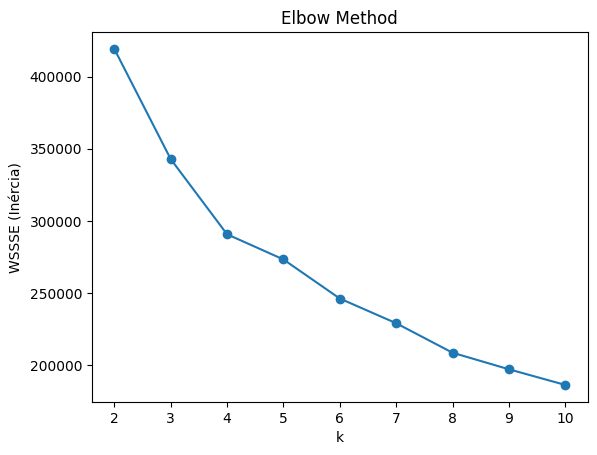

In [30]:
costs = []

for k in range(2, 11):  # test k from 2 to 10
    kmeans = KMeans(featuresCol='selected_features', predictionCol="cluster", k=k, maxIter=10)
    model = kmeans.fit(preprocessed_cluster_df)
    cost = model.summary.trainingCost  # WSSSE (Inércia)
    costs.append(cost)

# Plot
plt.plot(range(2, 11), costs, marker='o')
plt.xlabel("k")
plt.ylabel("WSSSE (Inércia)")
plt.title("Elbow Method")
plt.show()

In [31]:
kmeans = KMeans(featuresCol="selected_features", k=4, predictionCol="cluster", maxIter=10)
model = kmeans.fit(preprocessed_cluster_df)

df_clustered = model.transform(preprocessed_cluster_df)

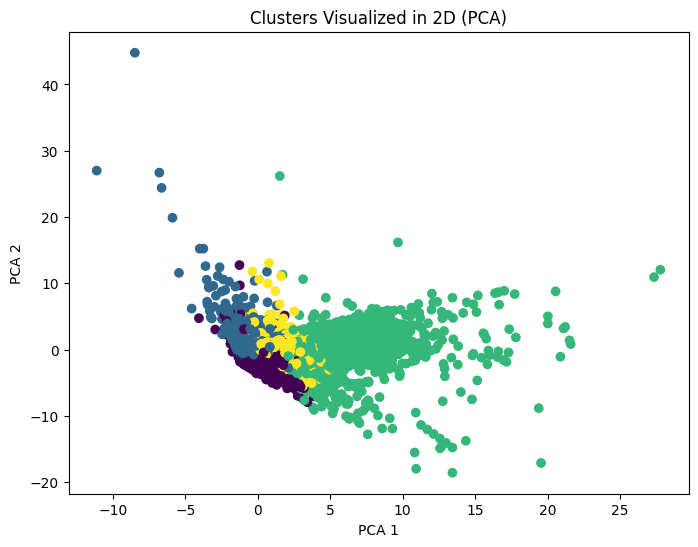

In [33]:
import pandas as pd

# Reduce to 2 dimensions
pca = PCA(k=2, inputCol="selected_features", outputCol="plot_features")
pca_model = pca.fit(df_clustered)
df_pca = pca_model.transform(df_clustered)

# Convert to Pandas
pandas_df = df_pca.select("plot_features", "cluster").toPandas()

# Extract PCA components
pandas_df["x"] = pandas_df["plot_features"].apply(lambda vec: vec[0])
pandas_df["y"] = pandas_df["plot_features"].apply(lambda vec: vec[1])

# Plot
plt.figure(figsize=(8,6))
plt.scatter(pandas_df["x"], pandas_df["y"], c=pandas_df["cluster"], cmap="viridis")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters Visualized in 2D (PCA)")
plt.show()


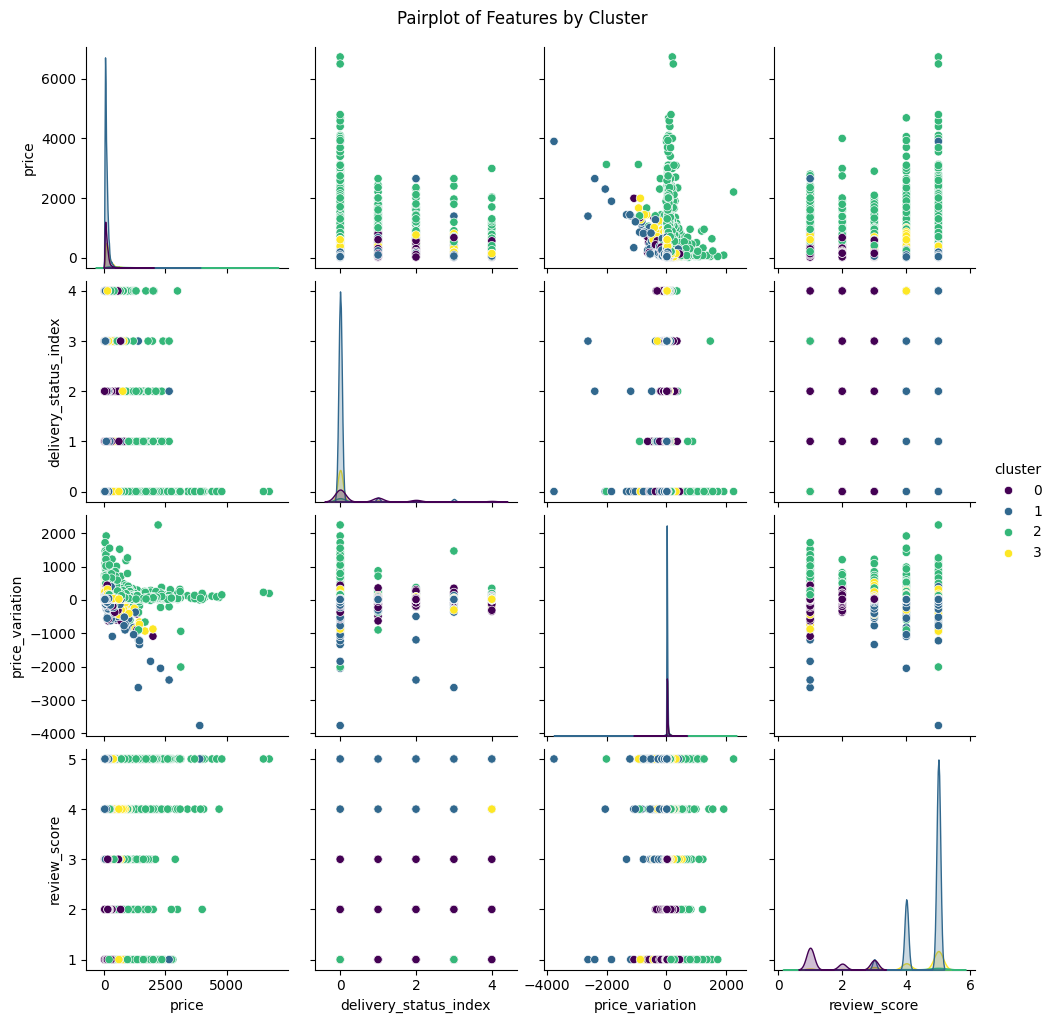

In [34]:
import seaborn as sns

selected_cols = ["price", "delivery_status_index", "price_variation", "review_score", "cluster"]
df_small = df_clustered.select(*selected_cols).toPandas()

# Step 2: Plot with seaborn
sns.pairplot(df_small, hue="cluster", diag_kind="kde", palette="viridis")
plt.suptitle("Pairplot of Features by Cluster", y=1.02)
plt.show()